In [1]:
import numpy as np
import pandas as pd
import keras
import imageio
import os
import sagemaker
import matplotlib.pyplot as plt
from keras.applications import VGG16,ResNet50
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
from PIL import Image
from glob import glob
from io import BytesIO

Using TensorFlow backend.


In [2]:
import boto3,urllib.request
from sagemaker import get_execution_role

In [3]:
s3_bucket = 'narayani1'
prefix = 'reverseimagesearch'

In [5]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()

In [6]:
rootdir = os.getcwd()

In [7]:
datadir = os.path.join(os.getcwd(),'ut-zap50k-images-square')
datadir

'/home/ec2-user/SageMaker/ut-zap50k-images-square'

In [ ]:
#read in image objs from s3 bucket

In [8]:
%%time
s3 = boto3.resource('s3')
bucket = s3.Bucket(name=s3_bucket)
objs = [obj for obj in bucket.objects.filter(Prefix='reverseimagesearch/data')]

CPU times: user 10.6 s, sys: 168 ms, total: 10.8 s
Wall time: 17.2 s


In [ ]:
#shuffle images when testing with smaller subset

In [ ]:
#import random
#random.shuffle(objs)

In [ ]:
#create vgg or resnet model

In [9]:
model = VGG16(weights='imagenet',include_top=True)

W0816 17:46:40.633351 139740661024576 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 17:46:40.653980 139740661024576 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 17:46:40.657370 139740661024576 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 17:46:40.685520 139740661024576 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:39

553467904/553467096 [==============================] - 7s 0us/step


W0816 17:46:48.349559 139740661024576 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816 17:46:48.350506 139740661024576 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [ ]:
#create 1x1000 vectors for each image in dataset from model predictions

In [10]:
def make_preds(smaller_set):
    images = [imageio.imread(BytesIO(obj.get()['Body'].read()),'jpg') for obj in smaller_set]
    ims = np.array([np.array(Image.fromarray(i).resize((224,224))) for i in images])
    out = model.predict(ims) # (500,1000) np array
    return out

In [ ]:
#create image vectors and add each vec as row of a dataframe

In [11]:
%%time
total = len(objs) #s3
s = 500
df = pd.DataFrame()
for i in range(0,total//s+1):
    start = i*s
    fin = start + s
    if fin > total:
        fin = total
    smaller_set = [objs[j] for j in range(start,fin)]
    #call predict
    if i < 5: #NOTE: this if is for only predicting a portion of data
        out = make_preds(smaller_set)
        df = df.append(pd.DataFrame(out))

CPU times: user 19min 15s, sys: 2.01 s, total: 19min 17s
Wall time: 11min 31s


In [12]:
df.shape

(2500, 1000)

In [ ]:
#convert df of image vecs to a csv and store in s3

In [13]:
df.to_csv('points2500.csv',header=None,index=None)
sagemaker_session.upload_data(
                            path=os.path.join(rootdir,'points2500.csv'),
                            bucket=s3_bucket,
                            key_prefix='{}/{}'.format(prefix,'points'))

's3://narayani1/reverseimagesearch/points/points2500.csv'

In [ ]:
#begin nearest neighbors to find closest matching shoes

In [14]:
import re, sys, math, json
import time
from sagemaker.sklearn.estimator import SKLearn

In [ ]:
#some paths in s3 bucket

In [15]:
data_path = 's3://narayani1/reverseimagesearch/points/points2500.csv'
model_path = 's3://narayani1/reverseimagesearch/model'
out_path = 's3://narayani1/reverseimagesearch/knn_output'
skout_path = 's3://narayani1/reverseimagesearch/sklearn_output'

In [ ]:
#declare path to sklearn model script and number of matches to find

In [74]:
script_path = 'sklearn_nearest_neighbors2.py'
k = 5

In [75]:
#create sklearn model using script and k

In [76]:
sklearn = SKLearn(
            entry_point=script_path,
            train_instance_type='ml.m4.xlarge',
            role=role,
            sagemaker_session=sagemaker_session,
            hyperparameters={'n_neighbors': k})

In [77]:
#fit the model using train data from the points csv created from vgg/resnet

In [78]:
%%time
sklearn.fit({'train': data_path})

2019-08-16 19:29:40 Starting - Starting the training job...
2019-08-16 19:29:43 Starting - Launching requested ML instances......
2019-08-16 19:30:47 Starting - Preparing the instances for training......
2019-08-16 19:32:00 Downloading - Downloading input data
2019-08-16 19:32:00 Training - Downloading the training image..
2019-08-16 19:32:19,325 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-08-16 19:32:19,328 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-08-16 19:32:19,341 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-08-16 19:32:19,601 sagemaker-containers INFO     Module sklearn_nearest_neighbors2 does not provide a setup.py. 
Generating setup.py
2019-08-16 19:32:19,601 sagemaker-containers INFO     Generating setup.cfg
2019-08-16 19:32:19,601 sagemaker-containers INFO     Generating MANIFEST.in
2019-08-16 19:32:19,602 sagemaker-containers INFO     Installing module w

In [ ]:
#deploy model, create endpoint

In [79]:
%%time
predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

---------------------------------------------------------------------------------------------------!CPU times: user 513 ms, sys: 24.5 ms, total: 538 ms
Wall time: 8min 20s


In [80]:
endpoint_name = predictor.endpoint
endpoint_name

'sagemaker-scikit-learn-2019-08-16-19-29-40-249'

# TESTING

In [ ]:
#TESTING
#Notes: this subset of the data was the first 2500 images without shuffling so higher indices aren't going to have matches
#add shuffle but remove test_case of test_im1

In [81]:
test_points = pd.read_csv(data_path, header=None)
points_arr = test_points.values

In [82]:
test_point = points_arr[0]
test_point.shape

(1000,)

In [83]:
test_point = np.expand_dims(test_point,axis=0)
test_point.shape

(1, 1000)

In [84]:
results = predictor.predict(test_point)
results

array([   0, 1780, 1602, 1356,  285])

In [ ]:
#testing images within the smaller dataset used to create knn (objs index 0-2499)
#output/first closest match should be the image itself

In [85]:
test_im1 = objs[0]

<function matplotlib.pyplot.show(*args, **kw)>

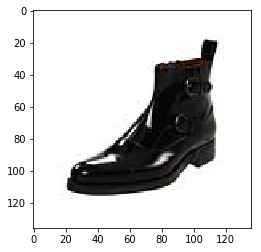

In [86]:
test_im1 = imageio.imread(BytesIO(test_im1.get()['Body'].read()),'jpg')
plt.imshow(test_im1)
plt.show

In [87]:
test_im1 = np.array(Image.fromarray(test_im1).resize((224,224)))
test_im1 = np.expand_dims(test_im1,axis=0)
test_im1.shape

(1, 224, 224, 3)

In [88]:
test_im1_pred = model.predict(test_im1)
test_im1_pred.shape

(1, 1000)

In [89]:
test_im1_results = predictor.predict(test_im1_pred)
test_im1_results

array([   0, 1780, 1602, 1356,  285])

In [106]:
def show_resulting_matches(results):
    fig = plt.figure()
    n = 1
    for i in results: 
        a = fig.add_subplot(1,k,n)
        im = imageio.imread(BytesIO(objs[i].get()['Body'].read()),'jpg')
        plt.imshow(im)
        title = 'Nearest Neighbor ' + str(n)
        a.set_title(title)
        n = n+1
    plt.show

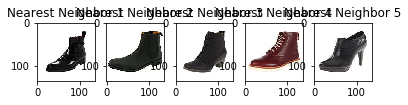

In [107]:
show_resulting_matches(test_im1_results)

In [ ]:
#testing images not in subset

<function matplotlib.pyplot.show(*args, **kw)>

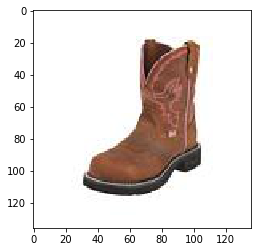

In [150]:
test_im2 = objs[2500]
test_im2 = imageio.imread(BytesIO(test_im2.get()['Body'].read()),'jpg')
plt.imshow(test_im2)
plt.show

In [151]:
test_im2 = np.array(Image.fromarray(test_im2).resize((224,224)))
test_im2 = np.expand_dims(test_im2,axis=0)
test_im2_pred = model.predict(test_im2)
test_im2_results = predictor.predict(test_im2_pred)

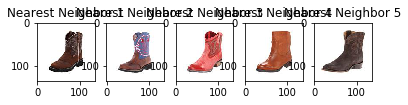

In [152]:
show_resulting_matches(test_im2_results)